# Project: Deep Research with LangGraph - Module 3: Research Agent with MCP

# Research Agent with MCP

In [1]:
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

In previous module, we built a research agent that will apply a custom search tool to gather information about a research topic. Additionally, we can also use the [Model Context Protocol (MCP)](https://modelcontextprotocol.io/specification/2025-06-18/architecture) as another way to access tools.

MCP servers provide a standard protocol for accessing tools.

[LangChain MCP Adapters](https://github.com/langchain-ai/langchain-mcp-adapters) provides a seamless bridge between the MCP and LangChain/LangGraph ecosystems.

In this module, we will build a research agent that uses the [Filesystem MCP Server](https://github.com/modelcontextprotocol/servers/tree/main/src/filesystem) to provide secure, controlled access to local file systems with granular permission management.


The **Filesystem MCP Server** will provide:
- **File operations** with strict access control
- **Directory management** with dynamic permissions
- **Search capabilities** across allowed directories
- **Metadata access** for files and directories

It has the following tools:
- **File operations**: `read_file`, `write_file`, `edit_file`, `read_multiple_files`
- **Directory management**: `create_directory`, `list_directory`, `move_file`
- **Search & discovery**: `search_files`, `get_file_info`, `list_allowed_directories`

# Prompt

We first will define a prompt that instructs our agent to use available search tools.

In [2]:
from utils import show_prompt
from deep_research_from_scratch.prompts import research_agent_prompt_with_mcp

show_prompt(research_agent_prompt_with_mcp, "Research Agent Instructions with MCP")

╭───────────────────────────────────── Research Agent Instructions with MCP ──────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic using local files. For context,     │
│  today's date is {date}.                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use file system tools to gather information from local research files.                          │
│  You can use any of the tools provided to you to find and read files that help answer the research question.    │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to file system tools and thinking tools:                                                       │
│  - **list_allowed_directories**: See what directories you can access                                            │
│  - **list_directory**: List files in directories                                                                │
│  - **read_file**: Read individual files                                                                         │
│  - **read_multiple_files**: Read multiple files at once                                                         │
│  - **search_files**: Find files containing specific content                                                     │
│  - **think_tool**: For reflection and strategic planning during research                                        │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after reading files to reflect on findings and plan next steps**                    │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with access to a document library. Follow these steps:                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Explore available files** - Use list_allowed_directories and list_directory to understand what's          │
│  available                                                                                                      │
│  3. **Identify relevant files** - Use search_files if needed to find documents matching the topic               │
│  4. **Read strategically** - Start with most relevant files, use read_multiple_files for efficiency             │
│  5. **After reading, pause and assess** - Do I have enough to answer? What's still missing?                     │
│  6. **Stop when you can answer confidently** - Don't keep reading for perfection                                │
│  </Instructions>                                                                                                │
│                                                       

# Research Tool

Next, we will use the *Filesystem MCP Server* to access research tools.

When using MCP tools with LangChain, we must use async methods because the MCP protocol is inherently asynchronous:
- Server communication uses async JSON-RPC over stdio/http
- Tool invocations involve network/IPC calls that can be slow
- Async enables non-blocking, concurrent operations

Hence, the **LangChain MCP Adapters** are designed for async-only operations:
- Tools are wrapped as async StructuredTools
- Sync invocation is intentionally not implemented
- This ensures consistent async behavior across all MCP tools

Async enables
- Concurrent tool execution
- Non-blocking server communication
- Better resource utilization
- Responsive applications

MCP servers run as subprocesses:
- Communication happens over pipes (stdin/stdout)
- These I/O operations are naturally async
- Blocking sync calls would freeze the entire process

In [ ]:
# Toy MCP Example
import os
from langchain_mcp_adapters.client import MultiServerMCPClient

from rich.console import Console
from rich.panel import Panel
from rich.table import Table

console = Console()

# Get the absolute path to our sample research docs
sample_docs_path = os.path.abspath('./files/')
console.print(f"[bold blue] Sample docs path:[/bold blue] {sample_docs_path}")

# Check if the directory exists
if os.path.exists(sample_docs_path):
    console.print(f"[green] Directory exists with files:[/green] {os.listdir(sample_docs_path)}")
else:
    console.print(f"[red] Directory does not exist![/red]")


# MCP Client configuration - filesystem server for local document access
mcp_config = {
    'filesystem': {
        'command': 'npx',
        'args': [
            '-y',  # Auto-install if needed
            '@modelcontextprotocol/server-filesystem',
            sample_docs_path,
        ],
        'transport': 'stdio',
    }
}

console.print(Panel("[bold yellow]Creating MCP Client...[/bold yellow]", expand=False))
client = MultiServerMCPClient(mcp_config)
console.print("[green] MCP Client created successfully![/green]")


# Test getting tools
console.print(Panel("[bold yellow] Getting tools...[/bold yellow]", expand=False))
tools = await client.get_tools()

# Create a rich table for tool display
table = Table(title="Available MCP Tools", show_header=True, header_style='bold magenta')
table.add_column('Tool Name', style='cyan', width=25)
table.add_column('Description', style='while', width=80)

for tool in tools:
    # Truncate long descriptions for better display
    description = tool.description[:80] + '...' if len(tool.description) > 80 else tool.description
    table.add_row(tool.name, description)

console.print(table)
console.print(f"[bold green] Successfully retrieved {len(tools)} tools from MCP server![/bold green]")

# Agent

Now, we will define our research agent that uses the MCP tools.

MCP servers run as separate subprocesses that communicate via
- **stdin/stdout pipes** for local servers
- **HTTP/WebSocket connections** for remote servers

Tool operations often involve
- File system operations (reading, writing, searching)
- Network requests (for remote MCP servers)
- Database queries (for data-backed servers)
- External API calls

These operations have variable latency and benefit from non-blocking async calls.

In [3]:
%%writefile ./src/deep_research_from_scratch/research_agent_mcp.py
"""Research Agent with MCP Integration.

Description: This module implements a research agent that integrates with Model Context Protocol (MCP)
servers to access tools and resources. The agent demonstrates how to use MCP filesystem
server for local document research and analysis.

Key features:
- MCP server integration for tool access
- Async operations for concurrent tool execution (required by MCP protocol)
- Filesystem operations for local document research
- Secure directory access with permission checking
- Research compression for efficient processing
- Lazy MCP client initialization for LangGraph Platform compatibility
"""
import os
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langgraph.graph import StateGraph, START, END
from langchain_mcp_adapters.client import MultiServerMCPClient

from deep_research_from_scratch.prompts import research_agent_prompt_with_mcp, compress_research_system_prompt, compress_research_human_message
from deep_research_from_scratch.state_research import ResearcherState, ResearcherOutputState
from deep_research_from_scratch.utils import get_today_str, think_tool, get_current_dir

# ===== CONFIGURATION =====

# MCP server configuration - filesystem server for local document access
mcp_config = {
    'filesystem': {
        'command': 'npx',
        'args': [
            '-y',  # Auto-install if needed
            '@modelcontextprotocol/server-filesystem',
            str(get_current_dir() / 'files') # Path to research documents
        ],
        'transport': 'stdio',  # Communication via stdin/stdout
    }
}

# Global client variable
_client = None

def get_mcp_client():
    """Get or initialize MCP client to avoid issues with LangGraph Platform."""
    global _client
    if _client is None:
        _client = MultiServerMCPClient(mcp_config)
    return _client


# Initialize chat model
compress_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000)
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514")


# ===== AGENT NODES =====

async def llm_call(state: ResearcherState):
    """Analyze current state and decide on tool usage with MCP integration.
    
    This node:
    1. Retrieve available tools from MCP server.
    2. Bind tools to the language model.
    3. Process user input and decide on tool usage.
    
    Return updated state with model response.
    """
    # Get available tools from MCP server
    client = get_mcp_client()
    mcp_tools = await client.get_tools()

    # Use MCP tools for local document access
    tools = [think_tool] + mcp_tools

    # Initialize model with tool binding
    model_with_tools = model.bind_tools(tools)

    # Process user input with system prompt
    response = model_with_tools.invoke(
        [SystemMessage(content=research_agent_prompt_with_mcp.format(date=get_today_str()))] + state["researcher_messages"]
    )

    return {'researcher_messages': [response]}


async def tool_node(state: ResearcherState):
    """Execute tool calls using MCP tools.
    
    This node:
    1. Retrieves current tool calls from the last message
    2. Executes all tool calls using async operations (required for MCP)
    3. Returns formatted tool results

    Note: MCP requires async operations due to inter-process communication
    with the MCP server subprocess. This is unavoidable.
    """
    tool_calls = state['researcher_messages'][-1].tool_calls

    async def execute_tools():
        """Execute all tool calls. MCP tools require async execution."""
        # Get fresh tool references from MCP server
        client = get_mcp_client()
        mcp_tools = await client.get_tools()
        tools = [think_tool] + mcp_tools
        tools_by_name = {tool.name: tool for tool in tools}

        # Execute tool calls (sequentially for reliability)
        observations = []
        for tool_call in tool_calls:
            tool = tools_by_name[tool_call['name']]
            if tool_call['name'] == 'think_tool':
                # think_tool is sync, use regular invoke
                observation = tool.invoke(tool_call['args'])
            else:
                # MCP tools are async, use ainvoke
                observation = await tool.ainvoke(tool_call['args'])
            observations.append(observation)

        # Format results as tool messages
        tool_outputs = [
            ToolMessage(
                content=observation,
                name=tool_call['name'],
                tool_call_id=tool_call['id']
            )
            for observation, tool_call in zip(observations, tool_calls)
        ]

        return tool_outputs

    messages = await execute_tools()

    return {'researcher_messages': messages}


def compress_research(state: ResearcherState) -> dict:
    """Compress research findings into a concise summary.

    Takes all the research messages and tool outputs and creates
    a compressed summary suitable for further processing or reporting.

    This function filters out think_tool calls and focuses on substantive
    file-based research content from MCP tools.
    """
    system_message = compress_research_system_prompt.format(date=get_today_str())
    messages = [SystemMessage(content=system_message)] + state.get("researcher_messages", []) + [HumanMessage(content=compress_research_human_message)]

    response = compress_model.invoke(messages)

    # Extract raw notes from tool and AI messages
    raw_notes = [
        str(m.content) for m in filter_messages(
            state['researcher_messages'],
            include_types=['tool', 'ai']
        )
    ]

    return {
        'compressed_research': str(response.content),
        'raw_notes': ['\n'.join(raw_notes)]
    }


# ===== ROUTING LOGIC =====

def should_continue(state: ResearcherState) -> Literal['tool_node', 'compress_research']:
    """Determine whether to continue with tool execution or compress research.

    Determines whether to continue with tool execution or compress research
    based on whether the LLM made tool calls.
    """
    messages = state['researcher_messages']
    last_message = messages[-1]

    # Continue to tool execution if tools were called
    if last_message.tool_calls:
        return 'tool_node'
    else:
        return 'compress_research'


# ===== GRAPH CONSTRUCTION =====

# Build agent workflow
agent_builder_mcp = StateGraph(
    ResearcherState,
    output_schema=ResearcherOutputState
)

# Add nodes
agent_builder_mcp.add_node('llm_call', llm_call)
agent_builder_mcp.add_node('tool_node', tool_node)
agent_builder_mcp.add_node('compress_research', compress_research)

# Add edges
agent_builder_mcp.add_edge(START, 'llm_call')
agent_builder_mcp.add_conditional_edges(
    'llm_call',
    should_continue,
    {
        'tool_node': 'tool_node',   # Continue to tool execution
        'compress_research': 'compress_research'  # Or compress research
    }
)
agent_builder_mcp.add_edge('tool_node', 'llm_call')  # Loop back to LLM after tool execution
agent_builder_mcp.add_edge('compress_research', END)  # End after compression

# Compile
agent_mcp = agent_builder_mcp.compile()

Overwriting ./src/deep_research_from_scratch/research_agent_mcp.py


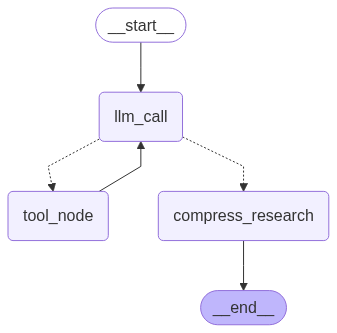

In [4]:
from IPython.display import Image, display
from deep_research_from_scratch.research_agent_mcp import agent_mcp

display(Image(agent_mcp.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Run the agent
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await agent_mcp.ainvoke({"researcher_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['researcher_messages'])

In [ ]:
from rich.markdown import Markdown
Markdown(result['compressed_research'])

# Understanding MCP

## The Client-Server Architecture

### Basic Client-Server Model

- **Client**: `MultiServerMCPClient` acts as the client that requests services
- **Server**: The MCP server provides tools and executes operations
- **Communication**: They communicate using a standardized protocol

```python
    client = MultiServerMCPClient(mcp_config)
```


In the LangChain MCP Adapters, the `MultiServerMCPClient` can
- start MCP servers based on configuration
- manage communication with one or more MCP servers
- convert MCP protocols to LangChain-compatible formats


### `mcp_config`

The `mcp_config` configuration tells the MCP client how to start and connect to MCP servers. For example,
```python
mcp_config = {
    "filesystem": {  # Server name (arbitrary label)
        "command": "npx",  # Command to run
        "args": ["-y", "@modelcontextprotocol/server-filesystem", "/path/to/docs"],
        "transport": "stdio"  # Communication method
    }
}
```

#### Configuration components
- **Server Name** (`"filesystem"`): An arbitrary label for this server instance
- **Command** (`"npx"`): The command to start the MCP server
- **Arguments** (`["-y", "@modelcontextprotocol/server-filesystem", "/path/to/docs"]`): Arguments to pass to the command
- **Transport** (`"stdio"`): The communication method (e.g., stdio, http)


#### Two transport methods

1. **stdio transport** (local servers):
    - Uses standard input/output for communication
    - Server runs as a subprocess on our local machine
    - Communication via pipes (stdin/stdout)

2. **http transport** (remote servers):
    - Uses HTTP requests for communication
    - Server runs on a remote machine or cloud service
    - Communication via HTTP/WebSocket endpoints


#### Remote MCP Servers
- Typeical URL format: `https://mcp.[company-name].com/sse`
- Requires authentication credentials and trust verification

Example remote config:
```python
mcp_config = {
    "remote_service": {
        "url": "https://mcp.example.com/sse",
        "transport": "http",
        "headers": {
            "Authorization": "Bearer your-token-here"
        }
    }
}
```